In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from utils.fingerprinter import Fingerprinter
from utils.visualization import plot_regression_histograms

from xgboost import XGBRegressor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datasets

In [10]:
train = pd.read_csv('../data/log_standardize_prefix/train.csv')
test = pd.read_csv('../data/log_standardize_prefix/test.csv')
with open('./hyperparameters/log_standardize_prefix/xgbr.json') as f:
    hyperparameters = json.load(f)
properties = train.columns[1:]

In [5]:
fingerprinter = Fingerprinter()

train_X = fingerprinter(train['SMILES'].tolist())
test_X = fingerprinter(test['SMILES'].tolist())

n_features = train_X.shape[1]
print(f'Fingerprints have {n_features} features')

Fingerprints have 2048 features


## XGB Models

In [12]:
xgbr_dict = {property_label : XGBRegressor(**hyperparameters['properties'][property_label]['hyperparameters'])
            for property_label in properties}

In [13]:
for property_label, xgbr in xgbr_dict.items():

    print(f'Training XGB Regressor for {property_label}...', end='')

    train_Y = train[property_label]
    xgbr.fit(train_X, train_Y)
    
    print(f'Done')

Training XGB Regressor for property_LPS_Abs...Done
Training XGB Regressor for property_LPS_Lum...Done
Training XGB Regressor for property_MPLA_Abs...Done
Training XGB Regressor for property_MPLA_Lum...Done
Training XGB Regressor for property_CpG_Abs...Done
Training XGB Regressor for property_cGAMP_Abs...Done
Training XGB Regressor for property_cGAMP_Lum...Done


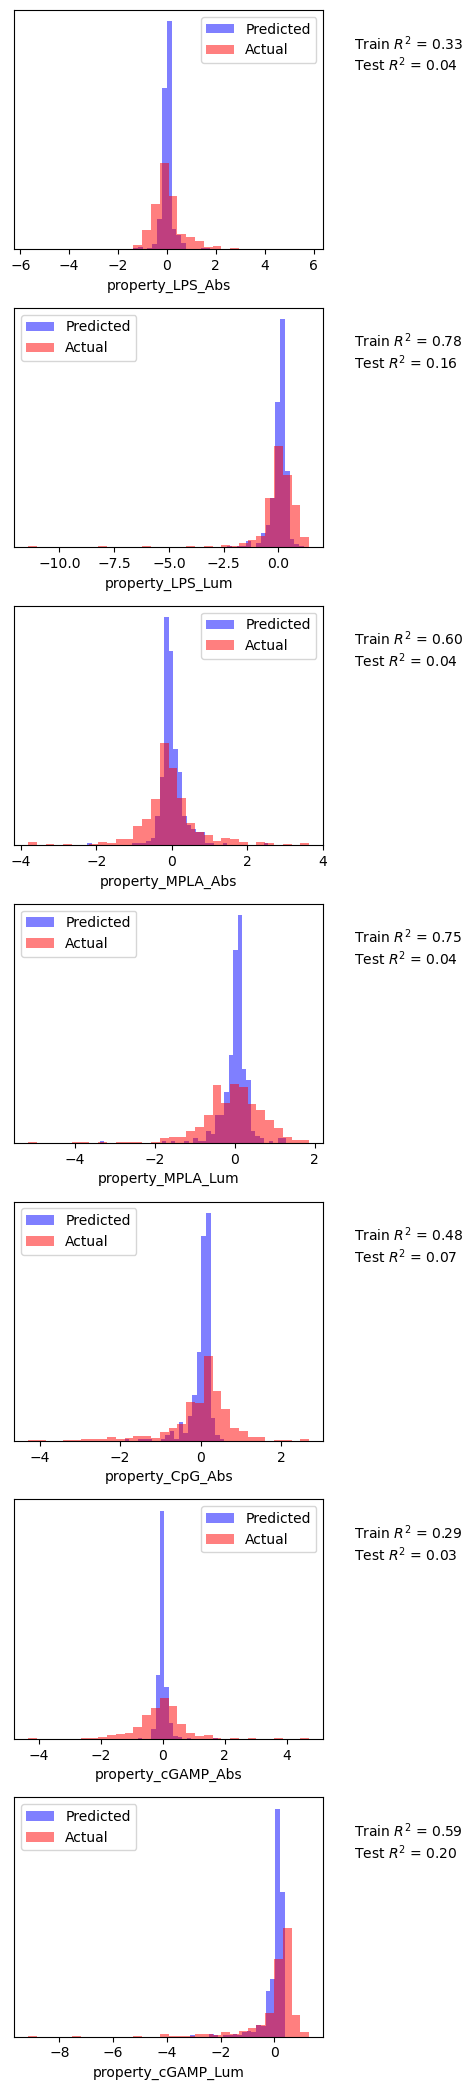

In [14]:
plot_regression_histograms(xgbr_dict, train_X, test_X, test, train)

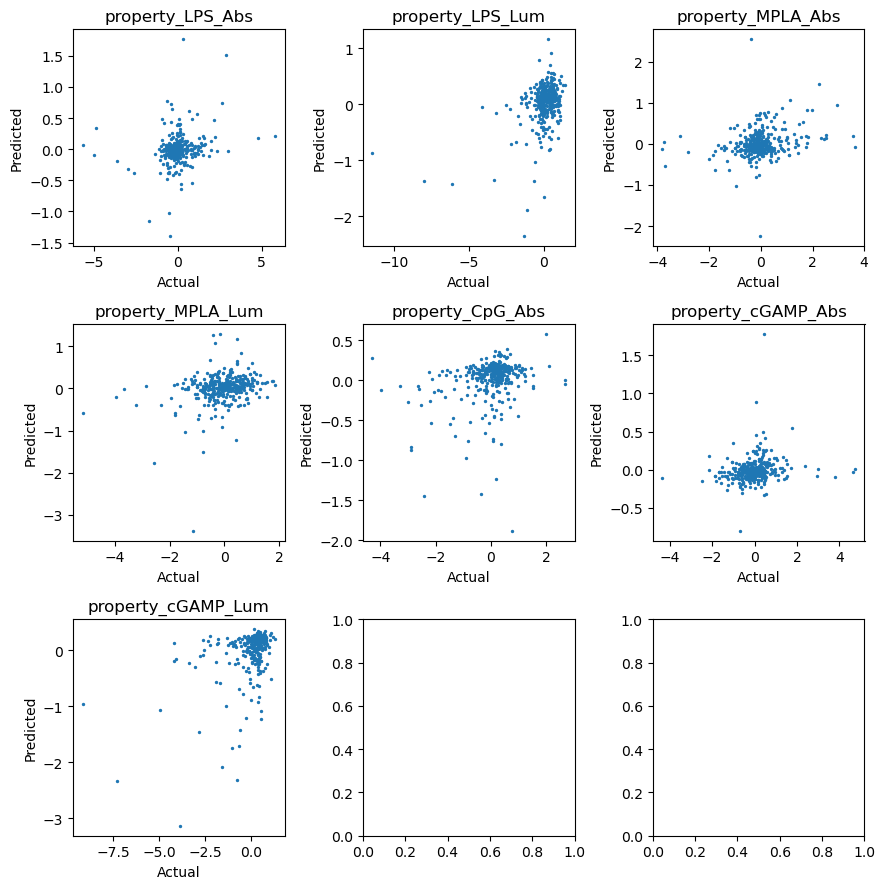

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(test.columns[1:]):

    ax = axs[i]

    xgbr = xgbr_dict[property_label]
    preds = xgbr.predict(test_X)

    ax.scatter(test.iloc[:, i+1], preds, s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)

plt.tight_layout()

In [23]:
#fig.savefig('./figures/predictions.pdf')